In [1]:
from typing import *
import os

import tqdm
import ase
import ase.io
import jax
import jax.numpy as jnp
import jraph
import pickle
import yaml
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append("../..")

from analyses import generate_molecules, analysis
from analyses.platonic_solids import train_classifier
from symphony.data import input_pipeline

Load classifier model.

In [2]:
model_dir = '/Users/ameyad/Documents/spherical-harmonic-net/analyses/platonic_solids/classifiers/nequip'
with open(os.path.join(model_dir, 'params.pkl'), "rb") as f:
    params = pickle.load(f)

classifier = train_classifier.create_model()


Generate structures.

In [3]:
def read_structures(structures_dir: str) -> List[ase.Atoms]:
    """Reads structures from the given directory."""
    structures = []
    for filename in os.listdir(structures_dir):
        filename = os.path.join(structures_dir, filename)
        structure = ase.io.read(filename)
        structures.append(structure)
    return structures


def generate_structures(workdir: str) -> List[ase.Atoms]:
    """Generates structures for the given workdir."""
    outputdir = '/Users/ameyad/Documents/spherical-harmonic-net/analyses/platonic_solids/structures'
    structures_dir = os.path.join(
        outputdir,
        analysis.name_from_workdir(workdir),
        "fait=1.0",
        "pit=1.0",
        "step=best",
        "molecules",
    )
    if not os.path.exists(structures_dir):
        generate_molecules.generate_molecules(workdir, outputdir, focus_and_atom_type_inverse_temperature=1., position_inverse_temperature=1., step="best", num_seeds=100, num_seeds_per_chunk=10, init_molecules="H", max_num_atoms=20, visualize=False)
    
    assert os.path.exists(structures_dir)
    return read_structures(structures_dir)
        

In [4]:
workdirs = {
    (piece, l, targets): f'/Users/ameyad/Documents/spherical-harmonic-net/potato_workdirs/platonic_solids_by_piece_meanangular_fixedcutoff/nequip/interactions=3/l={l}/lfocus=2/position_channels=2/channels=32/apply_gate=/square_logits=/piece={piece}/targets={targets}'
    for piece in [2]
    for l in [4]
    for targets in [1, 2, 3, 4, 5]
}

structures = {}
for key in tqdm.tqdm(workdirs):
    structures[key] = generate_structures(workdirs[key])

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [09:39<00:00, 115.98s/it]


Run on generated structures.

In [5]:
def prepare_structures(structures: Sequence[ase.Atoms]):
    """Converts a sequence of ase.Atoms to a batched jraph.GraphsTuple."""
    # Convert the list of ase.Atoms to a list of jraph.GraphsTuple.
    graphs = [input_pipeline.ase_atoms_to_jraph_graph(structure, atomic_numbers=[1, 6, 7, 8, 9], nn_cutoff=1.05) for structure in structures]
    # Batch the list of jraph.GraphsTuple.
    return jraph.batch(graphs)

In [6]:
results = {}
for key in workdirs:
    piece, l, targets = key
    structures_for_workdir = structures[key]
    graphs = prepare_structures(structures_for_workdir) 
    preds = classifier.apply(params, graphs)
    labels = jnp.ones_like(preds[:, 0], dtype=jnp.int32) * piece
    accuracy = jnp.mean(jnp.argmax(preds, axis=1) == labels)
    results[key] = accuracy

In [7]:
results_df = pd.DataFrame(columns=["piece", "l", "targets", "accuracy"])
for key in results:
    piece, l, targets = key
    results_df = pd.concat([results_df, pd.DataFrame([[piece, l, targets, results[key]]], columns=["piece", "l", "targets", "accuracy"])])
results_df = results_df.astype({"piece": int, "l": int, "targets": int, "accuracy": float})
results_df

,piece,l,targets,accuracy
0,2,4,1,0.930693
0,2,4,2,0.950495
0,2,4,3,0.960396
0,2,4,4,0.950495
0,2,4,5,0.950495


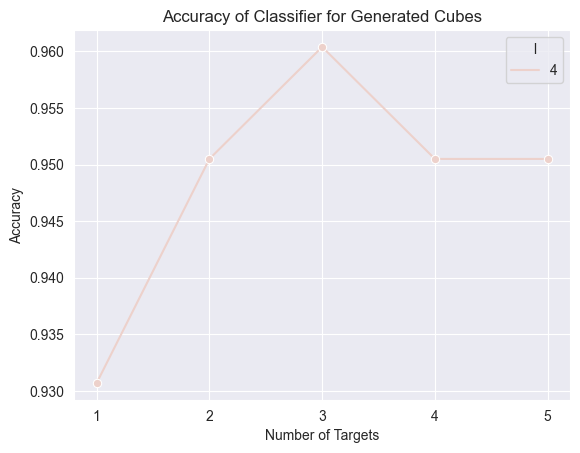

In [9]:
sns.set_style("darkgrid")
sns.lineplot(results_df, x="targets", y="accuracy", hue="l", marker="o")
plt.xticks(range(1, 6))
plt.xlabel("Number of Targets")
plt.ylabel("Accuracy")
plt.title("Accuracy of Classifier for Generated Cubes")
plt.show()